In [65]:
import pandas as pd

data_train = pd.read_csv('../data/train.csv')
data_train.head()

,Unnamed: 0,iupac,smiles,expt,calc
0,0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
2,3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
3,4,heptan-1-ol,CCCCCCCO,-4.21,-2.917
4,5,"3,5-dimethylphenol",Cc1cc(cc(c1)O)C,-6.27,-5.444


In [66]:
data_train = data_train[['smiles', 'calc']]

In [67]:
data_train.head()

,smiles,calc
0,CN(C)C(=O)c1ccc(cc1)OC,-9.625
1,CC(C)C=C,2.452
2,CCc1cnccn1,-5.809
3,CCCCCCCO,-2.917
4,Cc1cc(cc(c1)O)C,-5.444


In [68]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_morganfp_df(data,
                    smiles_col='smiles',
                    label_col='label',
                    radius = 2,
                    ) -> pd.DataFrame:
    """
    Funtion to calculate MorganFPs and return them as DF
    """
    # Use SMILES as index in df
    data_temp = data.set_index(smiles_col)

    # Temp dictionary to store data
    temp_dict = {}
    
    # List of SMILES fialed to convert to MOL
    failed_smiles = []

    # Set up fingerptint generator
    fpgen = AllChem.GetMorganGenerator(radius=radius,
                                       fpSize=4096)

    for smile in data_temp.index:
        temp_mol = Chem.MolFromSmiles(smile)
        if temp_mol:
            # Set up additional output to store bit info
            ao = AllChem.AdditionalOutput()
            ao.CollectBitInfoMap()
            fps = fpgen.GetFingerprint(temp_mol, additionalOutput=ao)
        else:
            failed_smiles.append(smile)
        
        temp_dict[smile] = {'morganfp':fps,
                            'bitinfo': ao.GetBitInfoMap(),
                            'label': data_temp.loc[smile, label_col]}
    
    morganfp_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    if len(failed_smiles) > 0:
        print(f'Warning: {len(failed_smiles)} SMILES failed to convert to mol')
    
    return morganfp_df




In [69]:
morganfp_train = get_morganfp_df(data_train, label_col='calc')
morganfp_train.head()

,morganfp,bitinfo,label
CN(C)C(=O)c1ccc(cc1)OC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{322: ((8, 1),), 695: ((11, 0),), 841: ((12, 1...",-9.625
CC(C)C=C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{66: ((1, 2),), 1366: ((4, 0),), 2049: ((1, 0)...",2.452
CCc1cnccn1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{378: ((4, 0), (7, 0)), 690: ((2, 2),), 724: (...",-5.809
CCCCCCCO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{541: ((5, 2),), 807: ((7, 0),), 1130: ((6, 2)...",-2.917
Cc1cc(cc(c1)O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{807: ((7, 0),), 875: ((2, 1), (4, 1), (6, 1))...",-5.444


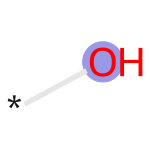

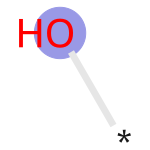

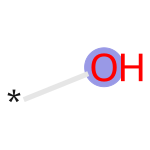

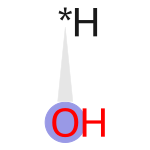

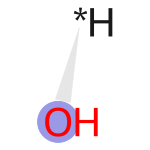

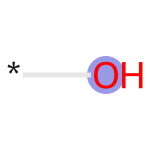

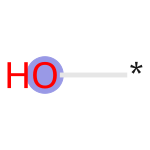

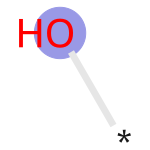

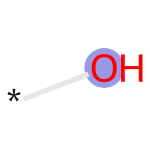

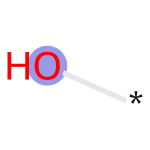

In [70]:
from rdkit.Chem import Draw

mols = []
bit = 807

for i, index in enumerate(morganfp_train.index):
    if bit in morganfp_train.loc[index, 'bitinfo'].keys():
        mols.append(i)

for row in mols[:10]:

    test_mol = Chem.MolFromSmiles(morganfp_train.index[row])
    bit_info = morganfp_train.iloc[row,1]

    mfp_svg = Draw.DrawMorganBit(test_mol, bit, bit_info, useSVG=False)
    display(mfp_svg)

In [71]:
morganfp_train.to_csv("../data/train_fp_bI.csv")

In [72]:
morganfp_train.iloc[0,:]

morganfp    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
bitinfo     {322: ((8, 1),), 695: ((11, 0),), 841: ((12, 1...
label                                                  -9.625
Name: CN(C)C(=O)c1ccc(cc1)OC, dtype: object

In [73]:
from rdkit.Chem import Draw

test_mol = Chem.MolFromSmiles(morganfp_train.index[1])
bit_info = morganfp_train.iloc[1,1]


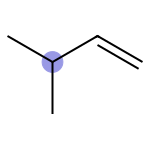

In [74]:
mfp2_svg = Draw.DrawMorganBit(test_mol, 66, bit_info, useSVG=True)
display(mfp2_svg)

In [75]:
train_dict = {}
for smile in morganfp_train.index:
    train_dict[smile] = {f'fp_{j}': i for j, i in enumerate(list(morganfp_train.loc[smile, 'morganfp']))}
    train_dict[smile].update({'label': morganfp_train.loc[smile, 'label']})

train_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_df.head()

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_4087,fp_4088,fp_4089,fp_4090,fp_4091,fp_4092,fp_4093,fp_4094,fp_4095,label
CN(C)C(=O)c1ccc(cc1)OC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-9.625
CC(C)C=C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.452
CCc1cnccn1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.809
CCCCCCCO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.917
Cc1cc(cc(c1)O)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.444


In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, CN(C)C(=O)c1ccc(cc1)OC to C1COCCO1
Columns: 4097 entries, fp_0 to label
dtypes: float64(1), int64(4096)
memory usage: 16.1+ MB


In [77]:
train_df.shape

(514, 4097)

In [78]:
train_df.to_csv('../data/train_fp.csv')

In [79]:
test_data = pd.read_csv('../data/test.csv')

In [80]:
test_data = test_data[['smiles', 'calc']]

In [81]:
morganfp_test = get_morganfp_df(test_data, label_col='calc')
morganfp_test.head()

,morganfp,bitinfo,label
CC(=O)N1CCCC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{369: ((4, 2), (7, 2)), 1028: ((5, 1), (6, 1))...",-7.831
CCC#N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{290: ((2, 2),), 1089: ((2, 1),), 2128: ((1, 0...",-2.491
CCCCCBr,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{251: ((5, 1),), 495: ((4, 1),), 728: ((5, 0),...",0.824
CC[C@@H](C)CO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{807: ((5, 0),), 1544: ((1, 1),), 2049: ((2, 0...",-2.995
CCNCC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1004: ((2, 1),), 1632: ((2, 2),), 2128: ((1, ...",-2.986


In [82]:
test_dict = {}
for smile in morganfp_test.index:
    test_dict[smile] = {f'fp_{j}': i for j, i in enumerate(list(morganfp_test.loc[smile, 'morganfp']))}
    test_dict[smile].update({'label': morganfp_test.loc[smile, 'label']})

test_df = pd.DataFrame.from_dict(test_dict, orient='index')
test_df.head()

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,...,fp_4087,fp_4088,fp_4089,fp_4090,fp_4091,fp_4092,fp_4093,fp_4094,fp_4095,label
CC(=O)N1CCCC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-7.831
CCC#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.491
CCCCCBr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.824
CC[C@@H](C)CO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.995
CCNCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.986


In [83]:
test_df.to_csv('../data/test_fp.csv')